# Intel Image Classification
### Proje Özeti

**Amaç:** 6 sınıflı görüntü sınıflandırma (Buildings, Forest, Glacier, Mountain, Sea, Street) için CNN tabanlı bir model kurmak

**Boru hattı:** Veri keşfi → Önişleme → Augmentation → CNN eğitimi → Değerlendirme (eğri, rapor, confusion matrix) → Grad‑CAM → Hiperparametre denemeleri → Sonuç

In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/14986.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/3138.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/1700.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/16257.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/2863.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/771.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/12167.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/17643.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/6560.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/10162.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/4009.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/15823.jpg
/kaggle/input/intel-image-classification/seg_tr

### 2 - Veri Önişleme

In [13]:
BASE = "/kaggle/input/intel-image-classification"
TRAIN_DIR = f"{BASE}/seg_train/seg_train"
TEST_DIR  = f"{BASE}/seg_test/seg_test"

import os, itertools
for p in [TRAIN_DIR, TEST_DIR]:
    print(p, "->", os.path.exists(p))
    for cls in sorted(os.listdir(p))[:6]:
        print(" ", cls, ":", len(os.listdir(os.path.join(p, cls))))


/kaggle/input/intel-image-classification/seg_train/seg_train -> True
  buildings : 2191
  forest : 2271
  glacier : 2404
  mountain : 2512
  sea : 2274
  street : 2382
/kaggle/input/intel-image-classification/seg_test/seg_test -> True
  buildings : 437
  forest : 474
  glacier : 553
  mountain : 525
  sea : 510
  street : 501


In [14]:
from collections import Counter, defaultdict
def count_imgs(root):
    c = defaultdict(int)
    for cls in os.listdir(root):
        p = os.path.join(root, cls)
        if os.path.isdir(p):
            c[cls] += len([f for f in os.listdir(p) if f.lower().endswith(('.jpg','.png','.jpeg'))])
    return dict(c)

train_counts = count_imgs(TRAIN_DIR)
test_counts  = count_imgs(TEST_DIR)
train_counts, test_counts

({'mountain': 2512,
  'street': 2382,
  'buildings': 2191,
  'sea': 2274,
  'forest': 2271,
  'glacier': 2404},
 {'mountain': 525,
  'street': 501,
  'buildings': 437,
  'sea': 510,
  'forest': 474,
  'glacier': 553})

## 2. Veri Önişleme

- Klasör yapısı doğrulandı, sınıf isimlerini ve adetlerini kontrol edildi
- Train klasöründen validation için %20 ayrıldı.
- Görüntüler 224×224'e yeniden boyutlandırıldı ve [0,1] aralığına normalize edildi.
- tf.data ile prefetch kullanılarak veri yükleme hızlandırıldı.

In [15]:
IMG_SIZE = (224, 224)
BATCH = 32
SEED = 42

import tensorflow as tf
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, image_size=IMG_SIZE, batch_size=BATCH,
    validation_split=0.2, subset="training", seed=SEED)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, image_size=IMG_SIZE, batch_size=BATCH,
    validation_split=0.2, subset="validation", seed=SEED)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR, image_size=IMG_SIZE, batch_size=BATCH, shuffle=False)
class_names = train_ds.class_names
class_names


Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [16]:
normalizer = tf.keras.layers.Rescaling(1./255)
def add_norm(ds): 
    return ds.map(lambda x,y: (normalizer(x), y), num_parallel_calls=tf.data.AUTOTUNE)

train_ds = add_norm(train_ds).prefetch(tf.data.AUTOTUNE)
val_ds   = add_norm(val_ds).prefetch(tf.data.AUTOTUNE)
test_ds  = add_norm(test_ds).prefetch(tf.data.AUTOTUNE)


### Data Augmentation (sadece eğitim setinde)

Kullandıklarımız: `RandomFlip`, `RandomRotation`, `RandomZoom`, `RandomContrast`.
Amaç: Genelleme gücünü artırmak, overfitting riskini azaltmak.

## 3. Model Mimarisi (Baseline CNN)

Bloklar: `Conv(3×3) + ReLU + Conv(3×3) + ReLU + MaxPool + Dropout` × 3 → `Flatten` → `Dense(256)` → `Dropout` → `Dense(6, softmax)`.

- Düzenlileştirme: `Dropout`
- Kayıp: `sparse_categorical_crossentropy`. Metrik: `accuracy`
- Optimizasyon: `Adam (lr=1e-3)`.

In [17]:
data_augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])


In [18]:
def add_aug(ds):
    return ds.map(lambda x,y: (data_augment(x, training=True), y),
                  num_parallel_calls=tf.data.AUTOTUNE)

train_ds = add_aug(train_ds).prefetch(tf.data.AUTOTUNE)


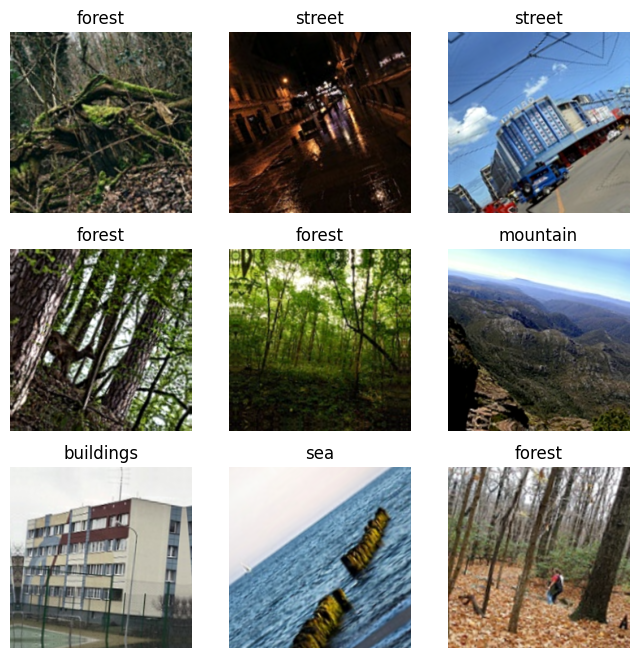

In [19]:
import matplotlib.pyplot as plt
images, labels = next(iter(train_ds))
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()


In [20]:
# Kaba tahmin: train klasör sayımlarından
import numpy as np
counts = np.array([train_counts[c] for c in class_names], dtype=float)
inv = counts.sum() / (len(class_names) * counts)
class_weight = {i: w for i, w in enumerate(inv)}
class_weight


{0: 1.067549064354176,
 1: 1.0299427564949362,
 2: 0.9729617304492513,
 3: 0.9311305732484076,
 4: 1.0285839929639402,
 5: 0.9819479429051218}

### 3 - Modelin Eğitilmesi

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

NUM_CLASSES = len(class_names)
INPUT_SHAPE = IMG_SIZE + (3,)

def build_baseline(dropout=0.3, l2=0.0, filters=(32,64,128)):
    reg = keras.regularizers.l2(l2) if l2>0 else None
    inputs = keras.Input(shape=INPUT_SHAPE)
    x = inputs
    for f in filters:
        x = layers.Conv2D(f, 3, padding="same", activation="relu", kernel_regularizer=reg)(x)
        x = layers.Conv2D(f, 3, padding="same", activation="relu", kernel_regularizer=reg)(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Dropout(dropout)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu", kernel_regularizer=reg)(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    return model

model = build_baseline(dropout=0.3, l2=1e-4, filters=(32,64,128))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,978,918 (99.10 MB)

 Trainable params: 25,978,918 (99.10 MB)

 Non-trainable params: 0 (0.00 B)

## 3.1 Eğitim Stratejisi ve Callback'ler

- `EarlyStopping(patience=5, restore_best_weights=True)` ile en iyi ağırlıklara dön.
- `ReduceLROnPlateau` ile takılma durumunda öğrenme oranını düşür.
- `ModelCheckpoint` ile en iyi modeli kaydet.

In [22]:
cb = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy"),
    keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-5, monitor="val_loss"),
    keras.callbacks.ModelCheckpoint("best_baseline.keras", save_best_only=True, monitor="val_accuracy"),
]

EPOCHS = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=cb,
    # class_weight=class_weight  # dengesizlik görürsen aç
)


Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 71s 180ms/step - accuracy: 0.3523 - loss: 1.8633 - val_accuracy: 0.5934 - val_loss: 1.0296 - learning_rate: 0.0010
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 73s 165ms/step - accuracy: 0.5662 - loss: 1.1295 - val_accuracy: 0.6568 - val_loss: 0.9268 - learning_rate: 0.0010
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 58s 164ms/step - accuracy: 0.5936 - loss: 1.0558 - val_accuracy: 0.6668 - val_loss: 0.8994 - learning_rate: 0.0010
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 83s 166ms/step - accuracy: 0.6066 - loss: 1.0238 - val_accuracy: 0.6825 - val_loss: 0.8716 - learning_rate: 0.0010
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 58s 164ms/step - accuracy: 0.6249 - loss: 0.9841 - val_accuracy: 0.7006 - val_loss: 0.8495 - learning_rate: 0.0010
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 58s 165ms/step - accuracy: 0.6519 - loss: 0.9342 - val_accuracy: 0.7046 - val_loss: 0.8472 - learning_rate: 0.0010
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 58s 164ms/step - accuracy: 0.6

### 4 - Modelin Değerlendirilmesi

## 4.1 Öğrenme Eğrileri

- **Accuracy**: Eğitim ve doğrulama eğrilerinin yakın seyretmesi iyi genelleme belirtisi.
- **Loss**: Doğrulama kaybı yükselirken eğitim kaybı düşüyorsa overfitting sinyali.

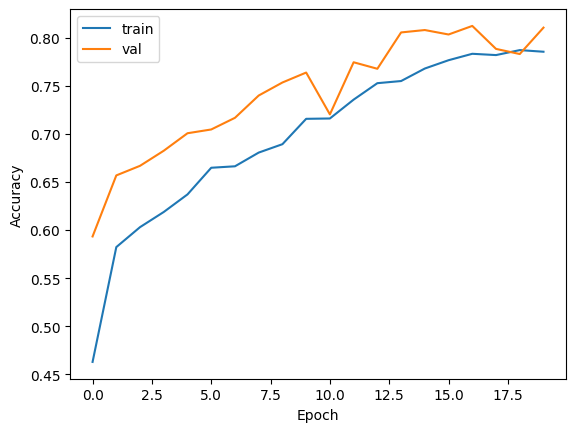

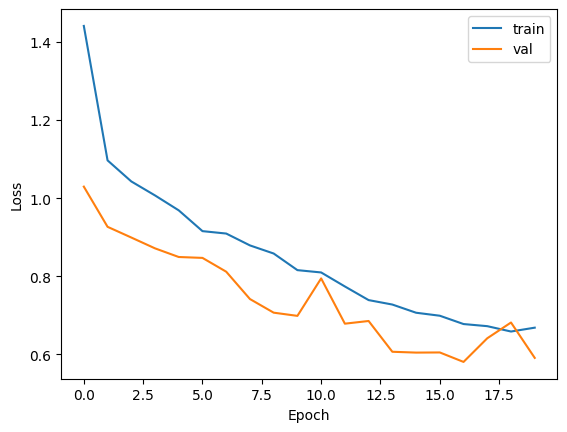

In [23]:
import matplotlib.pyplot as plt

plt.figure(); plt.plot(history.history["accuracy"]); plt.plot(history.history["val_accuracy"]); 
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(["train","val"]); plt.show()

plt.figure(); plt.plot(history.history["loss"]); plt.plot(history.history["val_loss"]);
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(["train","val"]); plt.show()


## 4.2 Değerlendirme: Classification Report ve Confusion Matrix

- `precision / recall / f1` skorlarını sınıf bazında incele.
- Confusion matrix'te en çok karışan sınıf çiftlerini yorumla ve örnek görselleri kontrol et.

              precision    recall  f1-score   support

   buildings       0.83      0.73      0.78       437
      forest       0.91      0.98      0.94       474
     glacier       0.77      0.79      0.78       553
    mountain       0.71      0.76      0.73       525
         sea       0.84      0.74      0.78       510
      street       0.80      0.84      0.82       501

    accuracy                           0.81      3000
   macro avg       0.81      0.81      0.81      3000
weighted avg       0.81      0.81      0.80      3000



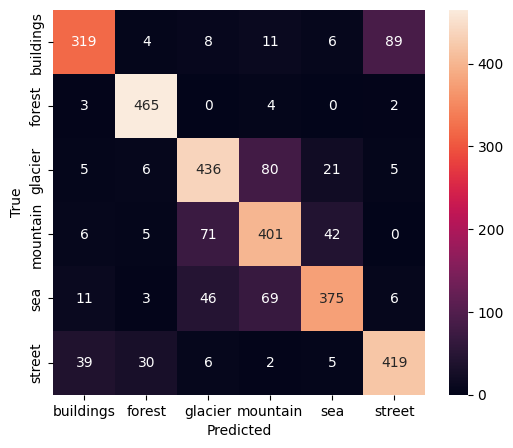

In [24]:
import numpy as np
y_true = []
y_pred = []

for X, y in test_ds:
    p = model.predict(X, verbose=0)
    y_true.extend(y.numpy())
    y_pred.extend(np.argmax(p, axis=1))

y_true = np.array(y_true); y_pred = np.array(y_pred)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
import seaborn as sns
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()


## 4.3 Açıklanabilirlik: Grad‑CAM

- Son konvolüsyon katmanının aktivasyonları ve gradyanları ile ısı haritası üretildi.
- Doğru/yanlış tahmin edilen örneklerde ısı haritasının **anlamlı bölgeleri** vurgulayıp yorumla.

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_27']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


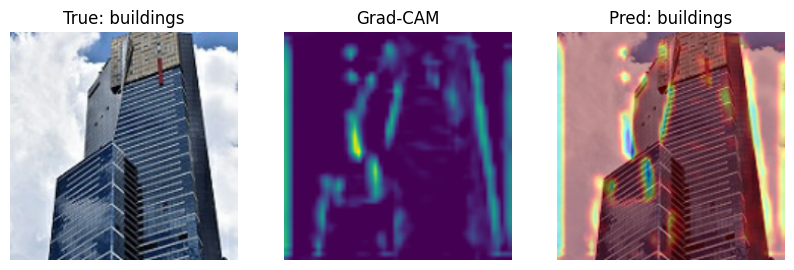

In [25]:
# Grad-CAM yardımcıları
last_conv_name = None
for layer in reversed(model.layers):
    if isinstance(layer, layers.Conv2D):
        last_conv_name = layer.name; break
assert last_conv_name is not None

grad_model = keras.Model(
    [model.inputs],
    [model.get_layer(last_conv_name).output, model.output]
)

def grad_cam(img_tensor):
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_tensor, training=False)
        class_idx = tf.argmax(preds[0])
        loss = preds[:, class_idx]
    grads = tape.gradient(loss, conv_out)
    pooled = tf.reduce_mean(grads, axis=(0,1,2))
    conv_out = conv_out[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled, conv_out), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return class_idx.numpy(), heatmap.numpy()

# Test setten tek bir görüntü al ve ısı haritasını bind et
import cv2
sample_batch = next(iter(test_ds.unbatch().batch(1)))
img, label = sample_batch
pred_idx, heat = grad_cam(img)

img_np = (img[0].numpy()*255).astype("uint8")
heat_resized = cv2.resize(heat, (img_np.shape[1], img_np.shape[0]))
heat_color = cv2.applyColorMap(np.uint8(255*heat_resized), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(img_np, 0.6, heat_color, 0.4, 0)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(img_np); plt.title(f"True: {class_names[int(label.numpy()[0])]}")
plt.axis("off")
plt.subplot(1,3,2); plt.imshow(heat_resized); plt.title("Grad-CAM")
plt.axis("off")
plt.subplot(1,3,3); plt.imshow(overlay); plt.title(f"Pred: {class_names[int(pred_idx)]}")
plt.axis("off"); plt.show()


### 5 - Hiperparametre Optimizasyonu

## 5. Hiperparametre Denemeleri

Denediğim değişkenler: filtre kümeleri, `dropout`, `L2`, `learning rate`, `batch size` ve `optimizer`.
- **Hızlı tarama** ile birkaç kombinasyon.

In [ ]:
search_space = [
    {"filters":(32,64,128), "dropout":0.3, "l2":1e-4, "lr":1e-3},
    {"filters":(32,64,128), "dropout":0.4, "l2":1e-4, "lr":5e-4},
    {"filters":(64,128,256), "dropout":0.3, "l2":1e-4, "lr":1e-3},
    {"filters":(32,64,128), "dropout":0.2, "l2":0.0,  "lr":1e-3},
]

results = []
for cfg in search_space:
    m = build_baseline(dropout=cfg["dropout"], l2=cfg["l2"], filters=cfg["filters"])
    m.compile(optimizer=keras.optimizers.Adam(cfg["lr"]),
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    h = m.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ], verbose=0)
    val_best = max(h.history["val_accuracy"])
    results.append((cfg, val_best))
sorted(results, key=lambda x: x[1], reverse=True)[:3]
